# Research Agent with Tool Selection

This notebook demonstrates the enhanced research agent that first selects which tools to use before gathering evidence for a claim.

In [8]:
from dotenv import load_dotenv
import json
import importlib
import os
from pprint import pprint

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage, SystemMessage
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Annotated, TypedDict
from IPython.display import Image, display

## Setup

First, we'll set up the environment and import the necessary tools.

In [9]:
MODEL = "mistral-nemo"
TEMPERATURE = 0
load_dotenv('../.env', override=True)

TOOL_REGISTRY = {
    'tools.calculator': ['multiply', 'add', 'divide'],
    'tools.wikipedia': ['wikipedia']
}

def import_function(module_name, function_name):
    """Dynamically imports a function from a module.

    Args:
        module_name: The name of the module (e.g., "my_module").
        function_name: The name of the function to import (e.g., "my_function").

    Returns:
        The imported function, or None if the module or function is not found.
    """
    try:
        module = importlib.import_module(module_name)
        function = getattr(module, function_name)
        return function
    except (ImportError, AttributeError) as e:
        print(f"Error: Could not import function '{function_name}' from module '{module_name}'.")
        print(f"Exception: {e}")
        return None

tools = [import_function(module, function) for module,
         functions in TOOL_REGISTRY.items() for function in functions]
print(f"Tools: {[tool.__name__ for tool in tools]}")

Tools: ['multiply', 'add', 'divide', 'wikipedia']


## Initialize the LLM

We'll use Ollama with the Mistral-Nemo model.

In [10]:
llm = ChatOllama(
    model=MODEL,
    temperature=TEMPERATURE,
    # base_url="http://host.docker.internal:11434", # if running in the studio
).bind_tools(tools)

## Define the State and Load Prompts

We'll define the state structure and load the system prompts for both the research agent and the tool selection phase.

In [11]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    claim: str
    # New field to track tool selections
    tool_selections: dict
    # {'name': tool name, 'args': {kwargs}, 'result': str}
    evidence: list[dict]

with open('prompts/research_agent_system_prompt.txt', 'r') as f:
    sys_msg = SystemMessage(content=f.read())

with open('prompts/tool_selection_prompt.txt', 'r') as f:
    tool_selection_msg = SystemMessage(content=f.read())

## Define the Graph Nodes

Now we'll define the nodes for our LangGraph workflow.

In [12]:
def preprocessing(state: State):
    """
    Preprocesses state before sending to the assistant for tool routing.
    Currently, this just extracts the claim from the state and sets it as a HumanMessage
    following the SystemMessage
    """
    state['messages'] = [sys_msg, HumanMessage(content=state['claim'])]
    return state

def tool_selection(state: State) -> State:
    """
    Analyzes the claim and determines which tools would be appropriate to use.
    Returns a dictionary with tool names as keys and boolean values indicating
    whether each tool should be used.
    """
    # Create a message with the tool selection prompt and the claim
    messages = [tool_selection_msg, HumanMessage(content=state['claim'])]
    
    # Get the LLM's response
    response = llm.invoke(messages)
    
    # Extract the tool selections from the response
    try:
        # Try to parse the JSON directly from the response content
        selections_data = json.loads(response.content)
        tool_selections = selections_data.get('tool_selections', {})
    except json.JSONDecodeError:
        # If direct parsing fails, try to extract JSON from the text
        content = response.content
        start_idx = content.find('{')
        end_idx = content.rfind('}') + 1
        if start_idx >= 0 and end_idx > start_idx:
            json_str = content[start_idx:end_idx]
            try:
                selections_data = json.loads(json_str)
                tool_selections = selections_data.get('tool_selections', {})
            except json.JSONDecodeError:
                # If all parsing attempts fail, use default selections (all True)
                print("Failed to parse tool selections, using defaults")
                tool_selections = {
                    tool.__name__: {"selected": True, "reasoning": "Default selection"} 
                    for tool in tools
                }
        else:
            # If no JSON-like structure is found, use default selections
            tool_selections = {
                tool.__name__: {"selected": True, "reasoning": "Default selection"} 
                for tool in tools
            }
    
    # Print the tool selections for debugging
    print("Tool Selections:")
    for tool_name, selection in tool_selections.items():
        selected = selection.get('selected', False)
        reasoning = selection.get('reasoning', 'No reasoning provided')
        print(f"  {tool_name}: {selected} - {reasoning}")
    
    return {"tool_selections": tool_selections}

def assistant(state: State) -> State:
    """
    Uses the LLM to generate a response based on the claim and selected tools.
    """
    # Filter the tools based on the tool selections
    selected_tools = []
    for tool in tools:
        tool_name = tool.__name__
        selection = state['tool_selections'].get(tool_name, {})
        if selection.get('selected', False):
            selected_tools.append(tool)
    
    # If no tools were selected, use all tools as a fallback
    if not selected_tools:
        selected_tools = tools
        print("No tools were selected, using all tools as fallback")
    else:
        print(f"Using selected tools: {[tool.__name__ for tool in selected_tools]}")
    
    # Bind only the selected tools to the LLM
    llm_with_selected_tools = llm.bind_tools(selected_tools)
    
    # Generate a response using the selected tools
    response = llm_with_selected_tools.invoke(state['messages'])
    
    return {"messages": response}

def postprocessing(state: State) -> State:
    """
    Scan the message history to extract tool calls and results into tuples:
    (tool_name, tool_args, tool_result) for the 'evidence' list in the state
    """
    evidence = []
    for i in range(len(state['messages'])):
        message = state['messages'][i]
        if isinstance(message, AIMessage) and hasattr(message, 'tool_calls'):
            for tool_call in message.tool_calls:
                # Scan later messages for the corresponding ToolMessage
                for j in range(i + 1, len(state['messages'])):
                    next_message = state['messages'][j]
                    if isinstance(next_message, ToolMessage) and next_message.tool_call_id == tool_call['id']:
                        # Found the corresponding ToolMessage
                        evidence.append({
                            'name': tool_call['name'],
                            'args': tool_call['args'],
                            'result': next_message.content})
                        break

    return {'evidence': evidence}

## Build and Compile the Graph

Now we'll build the LangGraph workflow with the new tool selection node.

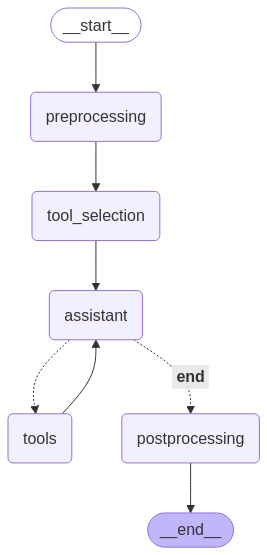

In [13]:
# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("preprocessing", preprocessing)
builder.add_node("tool_selection", tool_selection)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("postprocessing", postprocessing)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "preprocessing")
builder.add_edge("preprocessing", "tool_selection")
builder.add_edge("tool_selection", "assistant")
builder.add_conditional_edges(
    source="assistant",
    path=tools_condition,
    path_map={'tools': 'tools', '__end__': 'postprocessing'}
)
builder.add_edge("tools", "assistant")
builder.add_edge("postprocessing", END)

agent = builder.compile()

# Visualize the graph
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph visualization: {e}")

## Test with a Factual Claim

Let's test the agent with a factual claim that should use the Wikipedia tool.

In [14]:
factual_claim = "Albert Einstein developed the theory of relativity"
factual_result = agent.invoke({"claim": factual_claim})

print("\nFactual Claim Test:")
print(f"Claim: {factual_claim}")
print("\nTool Selections:")
for tool_name, selection in factual_result.get('tool_selections', {}).items():
    selected = selection.get('selected', False)
    reasoning = selection.get('reasoning', 'No reasoning provided')
    print(f"  {tool_name}: {selected} - {reasoning}")

print("\nEvidence:")
for evidence in factual_result.get('evidence', []):
    print(f"  Tool: {evidence['name']}")
    print(f"  Args: {evidence['args']}")
    print(f"  Result: {evidence['result'][:200]}..." if len(evidence['result']) > 200 else f"  Result: {evidence['result']}")
    print()

Tool Selections:
  wikipedia: True - This tool can provide information about historical figures and their contributions.
  multiply: False - No multiplication involved in this claim.
  add: False - No addition involved in this claim.
  divide: False - No division involved in this claim.
Using selected tools: ['wikipedia']
Using selected tools: ['wikipedia']

Factual Claim Test:
Claim: Albert Einstein developed the theory of relativity

Tool Selections:
  wikipedia: True - This tool can provide information about historical figures and their contributions.
  multiply: False - No multiplication involved in this claim.
  add: False - No addition involved in this claim.
  divide: False - No division involved in this claim.

Evidence:
  Tool: wikipedia
  Args: {'query': 'Theory of Relativity'}
  Result: The theory of relativity usually encompasses two interrelated physics theories by Albert Einstein: special relativity and general relativity, proposed and published in 1905 and 1915, respecti

## Test with a Mathematical Claim

Now let's test with a mathematical claim that should use the calculator tools.

In [15]:
math_claim = "12 multiplied by 10 equals 120"
math_result = agent.invoke({"claim": math_claim})

print("\nMathematical Claim Test:")
print(f"Claim: {math_claim}")
print("\nTool Selections:")
for tool_name, selection in math_result.get('tool_selections', {}).items():
    selected = selection.get('selected', False)
    reasoning = selection.get('reasoning', 'No reasoning provided')
    print(f"  {tool_name}: {selected} - {reasoning}")

print("\nEvidence:")
for evidence in math_result.get('evidence', []):
    print(f"  Tool: {evidence['name']}")
    print(f"  Args: {evidence['args']}")
    print(f"  Result: {evidence['result']}")
    print()

Tool Selections:
  wikipedia: False - Wikipedia is not relevant for mathematical calculations.
  multiply: True - This tool can be used to verify the multiplication claim.
  add: False - Addition is not applicable here.
  divide: False - Division is not applicable here.
Using selected tools: ['multiply']
Using selected tools: ['multiply']

Mathematical Claim Test:
Claim: 12 multiplied by 10 equals 120

Tool Selections:
  wikipedia: False - Wikipedia is not relevant for mathematical calculations.
  multiply: True - This tool can be used to verify the multiplication claim.
  add: False - Addition is not applicable here.
  divide: False - Division is not applicable here.

Evidence:
  Tool: multiply
  Args: {'a': 12, 'b': 10}
  Result: 120



## Test with a Mixed Claim

Finally, let's test with a claim that might need multiple tools.

In [16]:
mixed_claim = "If you multiply the distance from Earth to the Sun (93 million miles) by 2, you get 186 million miles"
mixed_result = agent.invoke({"claim": mixed_claim})

print("\nMixed Claim Test:")
print(f"Claim: {mixed_claim}")
print("\nTool Selections:")
for tool_name, selection in mixed_result.get('tool_selections', {}).items():
    selected = selection.get('selected', False)
    reasoning = selection.get('reasoning', 'No reasoning provided')
    print(f"  {tool_name}: {selected} - {reasoning}")

print("\nEvidence:")
for evidence in mixed_result.get('evidence', []):
    print(f"  Tool: {evidence['name']}")
    print(f"  Args: {evidence['args']}")
    print(f"  Result: {evidence['result'][:200]}..." if len(evidence['result']) > 200 else f"  Result: {evidence['result']}")
    print()

Tool Selections:
  wikipedia: False - This tool is not relevant as this is a mathematical calculation.
  multiply: True - This tool is directly applicable to the multiplication operation involved in the claim.
  add: False - There's no addition operation mentioned in the claim.
  divide: False - No division operation is involved in the claim.
Using selected tools: ['multiply']
Using selected tools: ['multiply']

Mixed Claim Test:
Claim: If you multiply the distance from Earth to the Sun (93 million miles) by 2, you get 186 million miles

Tool Selections:
  wikipedia: False - This tool is not relevant as this is a mathematical calculation.
  multiply: True - This tool is directly applicable to the multiplication operation involved in the claim.
  add: False - There's no addition operation mentioned in the claim.
  divide: False - No division operation is involved in the claim.

Evidence:
  Tool: multiply
  Args: {'a': 93000000, 'b': 2}
  Result: 186000000



## Examine the Full Message History

Let's look at the full message history for one of our examples to see the complete workflow.

In [17]:
print("Full Message History for Factual Claim:")
for i, message in enumerate(factual_result.get('messages', [])):
    print(f"\nMessage {i+1}:")
    print(f"Type: {type(message).__name__}")
    if hasattr(message, 'content'):
        if isinstance(message.content, str):
            print(f"Content: {message.content[:200]}..." if len(message.content) > 200 else f"Content: {message.content}")
        else:
            print(f"Content: {message.content}")
    if hasattr(message, 'tool_calls') and message.tool_calls:
        print("Tool Calls:")
        for tool_call in message.tool_calls:
            print(f"  Name: {tool_call['name']}")
            print(f"  Args: {tool_call['args']}")

Full Message History for Factual Claim:

Message 1:
Type: SystemMessage
Content: You are an **Evidence Retrieval Agent**. Your role is to retrieve supporting or contradictory evidence for a given claim using the tools available to you.  

### **Rules:**  
1. **Do Not Evaluate the ...

Message 2:
Type: HumanMessage
Content: Albert Einstein developed the theory of relativity

Message 3:
Type: AIMessage
Content: 
Tool Calls:
  Name: wikipedia
  Args: {'query': 'Theory of Relativity'}

Message 4:
Type: ToolMessage
Content: The theory of relativity usually encompasses two interrelated physics theories by Albert Einstein: special relativity and general relativity, proposed and published in 1905 and 1915, respectively. Spe...

Message 5:
Type: AIMessage
Content: Albert Einstein developed two interconnected theories known collectively as the theory of relativity:

1. **Special Relativity (1905)**: This theory applies to all physical phenomena in the absence of...


## Conclusion

The enhanced research agent now follows a two-step process:

1. First, it analyzes the claim and determines which tools would be most appropriate to use
2. Then, it uses only the selected tools to gather evidence about the claim

This approach provides several benefits:
- Increased transparency into the agent's decision-making process
- More efficient use of tools, only calling those that are relevant
- Better control over the evidence-gathering process
- Improved accuracy by focusing on the most appropriate tools for each claim